Pred: 1


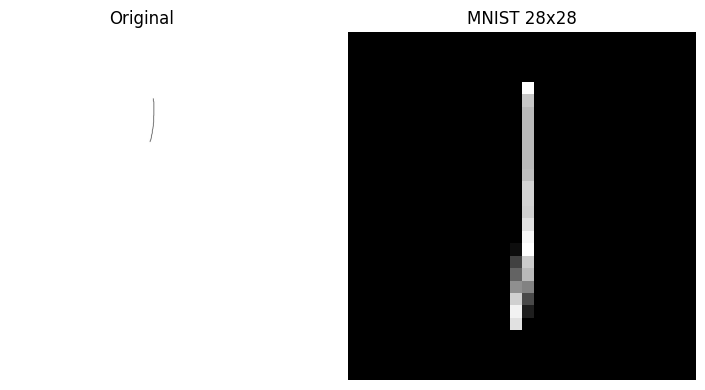

In [74]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage


def to_mnist_like_01(path: str, invert="auto"):
    img = Image.open(path).convert("L")
    arr = np.array(img).astype(np.float32)  # 0..255

    original = arr.copy()

    # Tar bort brus och skuggor
    arr = np.clip(arr * 3, 0, 255)

     # Auto-invert om bakgrunden är ljus
    if invert == "auto":
        if arr.mean() > 127:
            arr = 255.0 - arr
    elif invert is True:
        arr = 255.0 - arr
    
    # === X/255 ===
    arr01 = arr / 255.0

    # Binarisera
    bw = (arr01 > 0.25).astype(np.float32)

    coords = np.argwhere(bw > 0)
    if coords.size == 0:
        raise ValueError("Ingen siffra hittad.")

    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    cropped = bw[y0:y1, x0:x1]

    # Resize till max 20 pixlar
    h, w = cropped.shape
    scale = 20.0 / max(h, w)
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))

    cropped_img = Image.fromarray((cropped * 255).astype(np.uint8))
    resized = cropped_img.resize((new_w, new_h), Image.Resampling.BILINEAR)
    resized = np.array(resized).astype(np.float32) / 255.0

    # Pad till 28x28
    canvas = np.zeros((28, 28), dtype=np.float32)
    top = (28 - new_h) // 2
    left = (28 - new_w) // 2
    canvas[top:top + new_h, left:left + new_w] = resized

    # Center-of-mass
    cy, cx = ndimage.center_of_mass(canvas)
    shift_y = int(round(14 - cy)) if not np.isnan(cy) else 0
    shift_x = int(round(14 - cx)) if not np.isnan(cx) else 0
    canvas = ndimage.shift(canvas, shift=(shift_y, shift_x), order=1, mode="constant", cval=0.0)

    X = canvas.reshape(1, -1).astype(np.float32)

    return X, original, canvas


# --- predict ---
model = joblib.load("mnist_svc_production")

X, original_img, processed_img = to_mnist_like_01("siffra1.2.jpg", invert="auto")

y_pred = model.predict(X)[0]
print("Pred:", int(y_pred))


# --- VISUALISERING ---
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_img, cmap="gray")
plt.title("MNIST 28x28")
plt.axis("off")

plt.tight_layout()
plt.show()

